In [1]:
import pickle
import numpy as np

In [2]:
with open(r"C:\Users\ADMIN\UPDATED-NLP-COURSE\UPDATED_NLP_COURSE\06-Deep-Learning\train_qa.txt",'rb') as f:
    train_data=pickle.load(f)

In [3]:
with open(r"C:\Users\ADMIN\UPDATED-NLP-COURSE\UPDATED_NLP_COURSE\06-Deep-Learning\test_qa.txt",'rb') as f:
    test_data=pickle.load(f)

In [4]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [5]:
vocab = set()

In [6]:
all_data = test_data + train_data

In [7]:
for story, question , answer in all_data:

    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [8]:
vocab.add('no')
vocab.add('yes')

In [9]:
vocab_len = len(vocab) + 1

In [10]:
max_story_len = max([len(data[0]) for data in all_data])

In [11]:
max_question_len = max([len(data[1]) for data in all_data])

In [12]:
vocab_size = len(vocab) + 1

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
C:\Users\ADMIN\.conda\envs\tensorenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ADMIN\.conda\envs\tensorenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ADMIN\.conda\envs\tensorenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ADMIN\.conda\envs\tensorenv\lib\sit

In [14]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [15]:
tokenizer.word_index

{'took': 1,
 'journeyed': 2,
 'daniel': 3,
 '?': 4,
 'bathroom': 5,
 'hallway': 6,
 '.': 7,
 'to': 8,
 'moved': 9,
 'sandra': 10,
 'got': 11,
 'apple': 12,
 'in': 13,
 'kitchen': 14,
 'back': 15,
 'the': 16,
 'office': 17,
 'left': 18,
 'put': 19,
 'went': 20,
 'john': 21,
 'up': 22,
 'there': 23,
 'grabbed': 24,
 'dropped': 25,
 'garden': 26,
 'travelled': 27,
 'bedroom': 28,
 'down': 29,
 'is': 30,
 'yes': 31,
 'football': 32,
 'milk': 33,
 'no': 34,
 'discarded': 35,
 'mary': 36,
 'picked': 37}

In [16]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [17]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [18]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    
    

    
    X = []

    Xq = []
    
    Y = []
    
    
    for story, query, answer in data:
        
        
        x = [word_index[word.lower()] for word in story]
        
        xq = [word_index[word.lower()] for word in query]
        
        
        y = np.zeros(len(word_index) + 1)
        
        
        y[word_index[answer]] = 1
        
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
   
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [19]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [20]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [21]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [22]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [23]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))


Instructions for updating:
Colocations handled automatically by placer.


In [24]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [25]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [26]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [27]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [28]:
response = add([match, input_encoded_c])  
response = Permute((2, 1))(response)

In [29]:
answer = concatenate([response, question_encoded])
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [30]:
answer=LSTM(32)(answer)


In [31]:
answer=Dropout(0.5)(answer)

In [32]:
answer=Dense(vocab_size)(answer)

In [33]:
answer=Activation('softmax')(answer)

In [34]:
model=Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [36]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 20s 2ms/step - loss: 0.9009 - accuracy: 0.4955 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 2/120
10000/10000 [==============================] - 15s 1ms/step - loss: 0.7026 - accuracy: 0.5054 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 3/120
10000/10000 [==============================] - 15s 1ms/step - loss: 0.6970 - accuracy: 0.5014 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 15s 1ms/step - loss: 0.6956 - accuracy: 0.4969 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 5/120
10000/10000 [==============================] - 15s 2ms/step - loss: 0.6947 - accuracy: 0.4984 - val_loss: 0.6973 - val_accuracy: 0.4970
Epoch 6/120
10000/10000 [==============================] - 15s 1ms/step - loss: 0.694

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


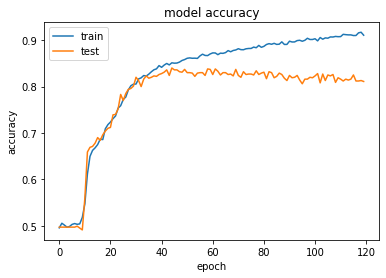

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [37]:
model.save('mybrandnewmodel.h5')
model.load_weights('mybrandnewmodel.h5')

In [38]:
story =' '.join(word for word in test_data[0][0])
print(story)
query = ' '.join(word for word in test_data[0][1])
print(query)

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?


In [39]:
print("True Test Answer from Data is:",test_data[0][2])
pred_results = model.predict(([inputs_test, queries_test]))

True Test Answer from Data is: no


In [40]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.033337425
